# EPE Detection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing&displaying

In [2]:
df = pd.read_csv('materials/processed_df.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             401 non-null    object 
 1   wiek                           401 non-null    float64
 2   PSA                            397 non-null    float64
 3   PSAdensity                     401 non-null    float64
 4   MRI vol                        401 non-null    float64
 5   MRI Pirads                     399 non-null    float64
 6   MRI EPE (naciek poza torebke)  401 non-null    float64
 7   MRI EPE L                      401 non-null    float64
 8   MRI EPE P                      401 non-null    float64
 9   MRI SVI (pecherzyki)           401 non-null    float64
 10  MRI SVI L                      400 non-null    float64
 11  MRI SVI P                      401 non-null    float64
 12  MRI SIZE                       371 non-null    flo

In [3]:
df.shape

(401, 31)

In [4]:
target = 'EPE RP'
col_wiek = 'wiek'
col_psa = 'PSA'
col_mri_vol = 'MRI vol'
col_biop_grade = 'Bx ISUP Grade'
col_pirads = 'MRI Pirads'
col_mri_esur = 'MRI EPE (naciek poza torebke)'
col_mri_svi = 'MRI SVI (pecherzyki)'
col_mri_size = 'MRI SIZE'

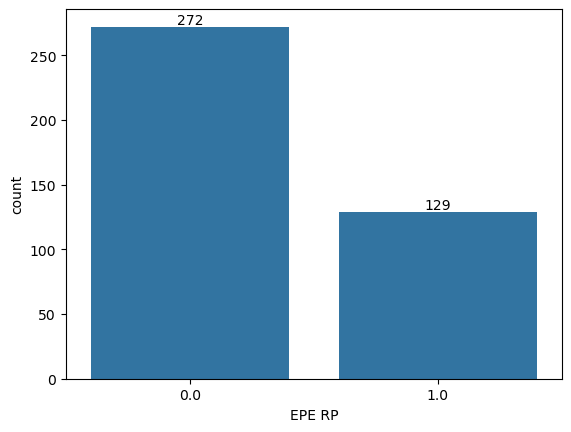

In [5]:
patients = len(df)
epe_dist = df[target].value_counts()

ax = sns.countplot(data=df, x=target)

for container in ax.containers:
    ax.bar_label(container)

plt.show(ax)

In [6]:
all_cols = [target, col_wiek, col_psa, col_mri_vol, col_biop_grade, col_pirads, col_mri_esur, col_mri_size, col_mri_svi]
continuous = [col_wiek, col_psa, col_mri_vol, col_mri_size]
categorical = [col_biop_grade, col_pirads, col_mri_esur, col_mri_svi]


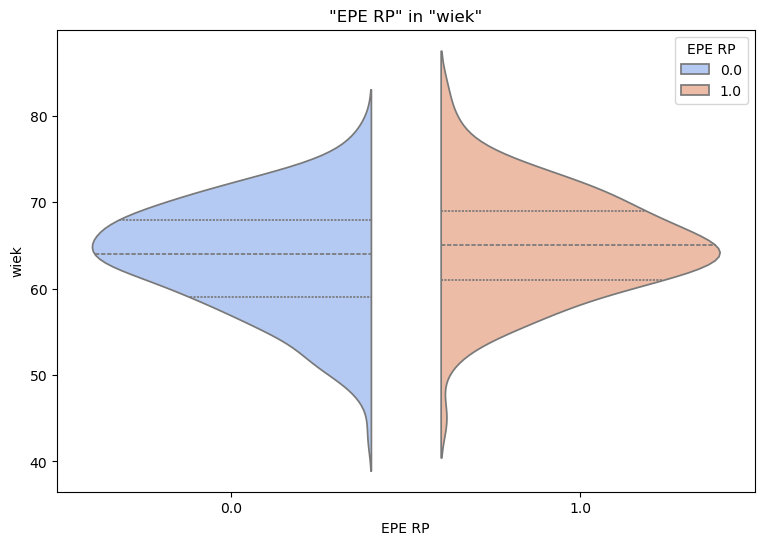

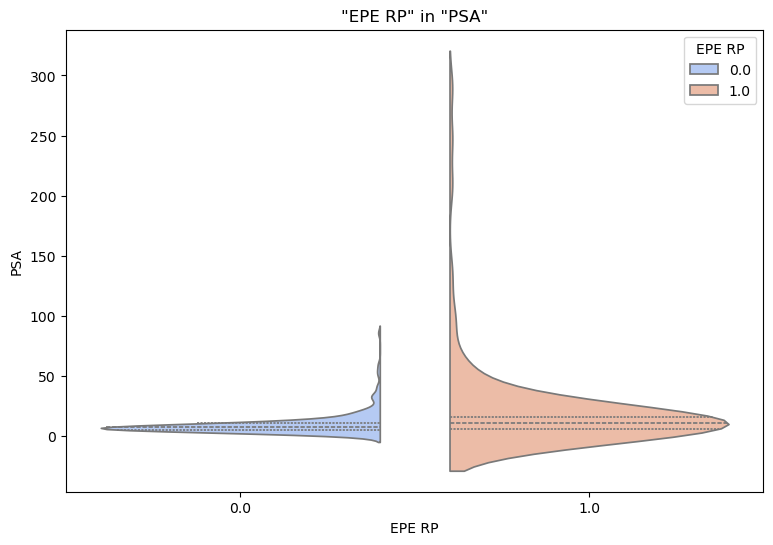

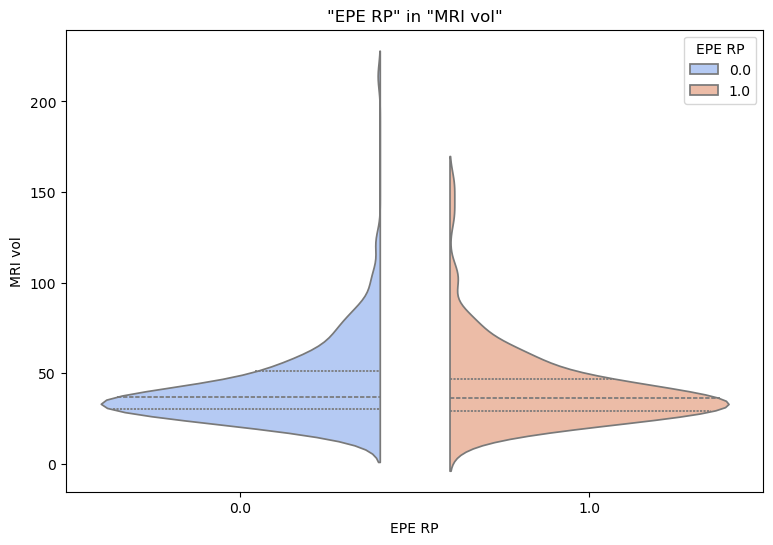

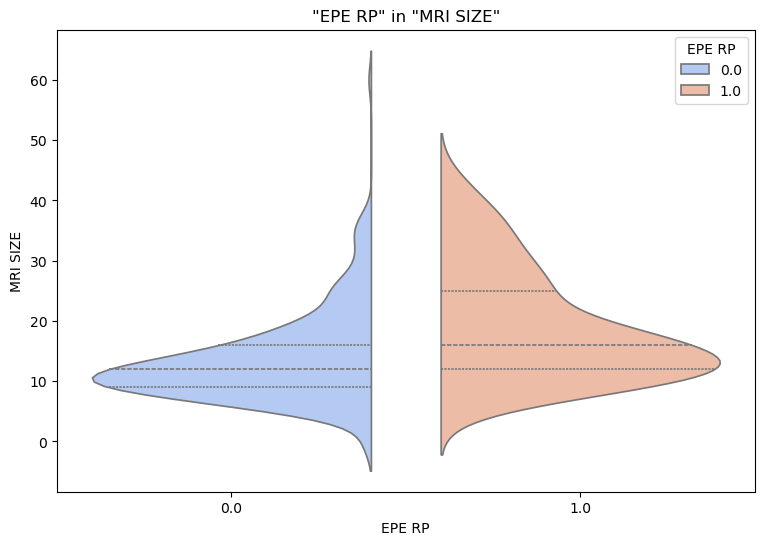

In [7]:
for col in continuous:
        plt.figure(figsize=(9, 6))
        sns.violinplot(x=target, y=col, hue=target, data=df, palette='coolwarm', split=True, inner='quartile')
        plt.title(f'"{target}" in "{col}"')
        plt.show()

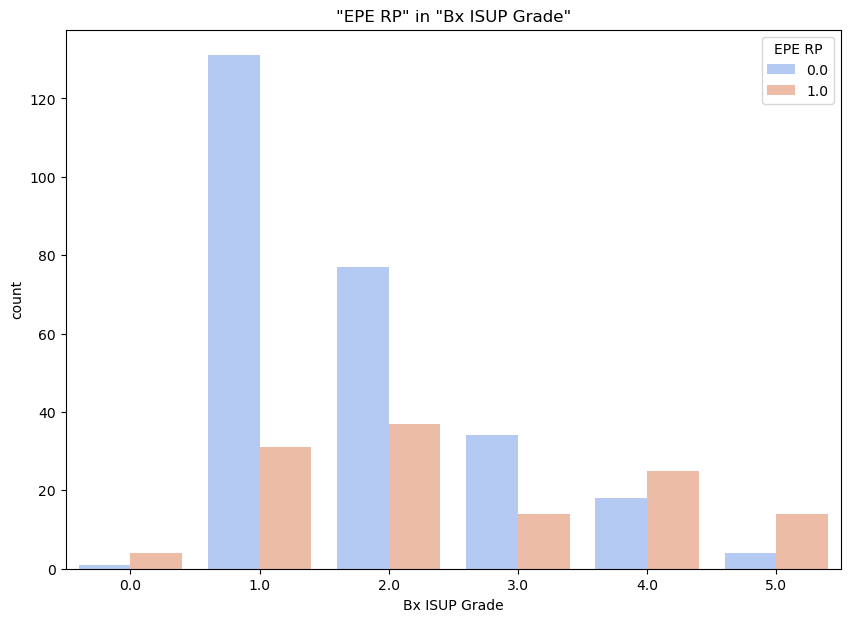

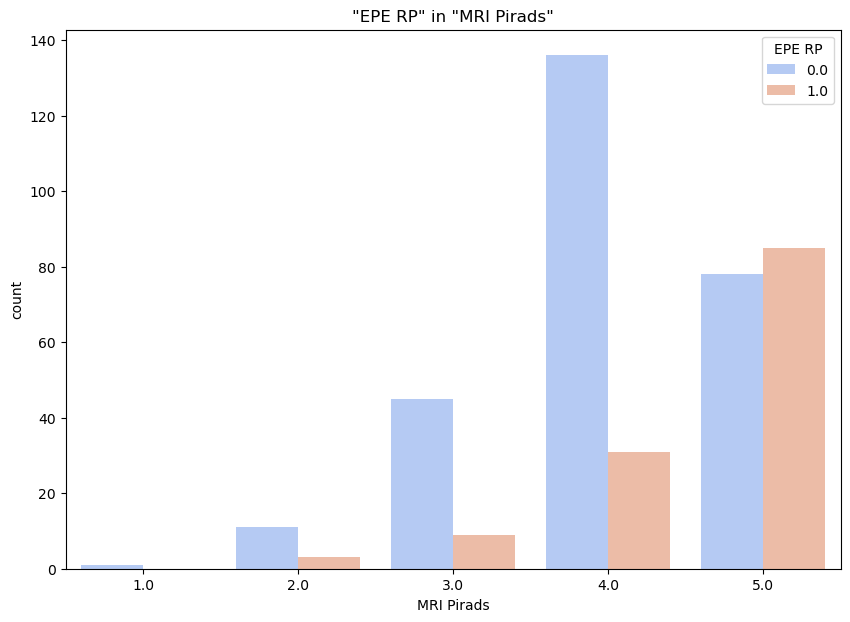

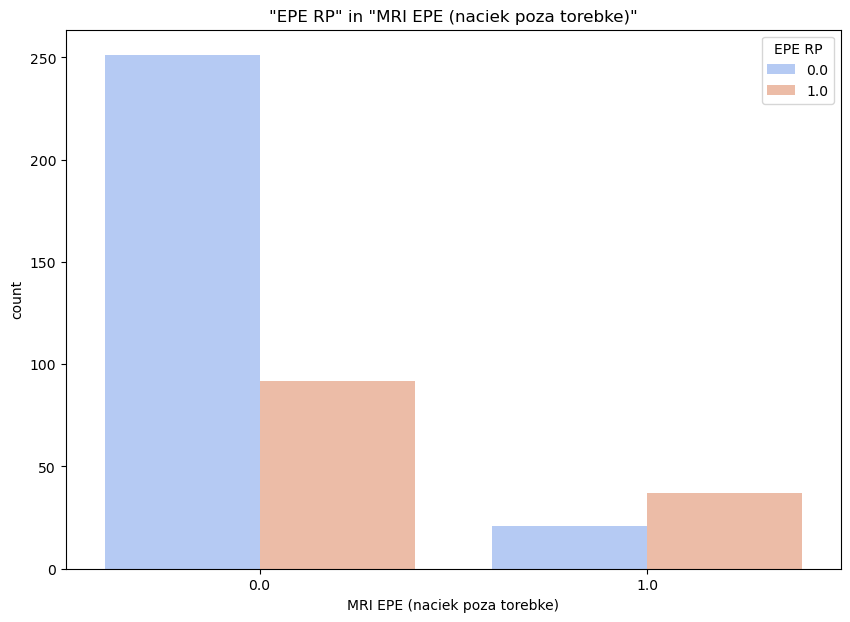

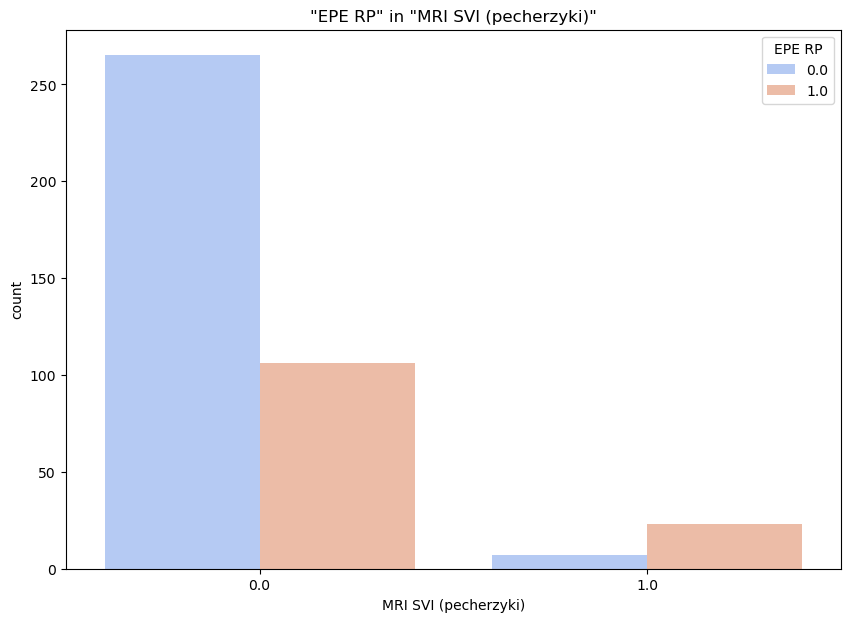

In [8]:
for col in categorical:
        plt.figure(figsize=(10, 7))
        
        sns.countplot(x=col, hue=target, data=df, palette='coolwarm')
        
        plt.title(f'"{target}" in "{col}"')
        
       
        plt.show()

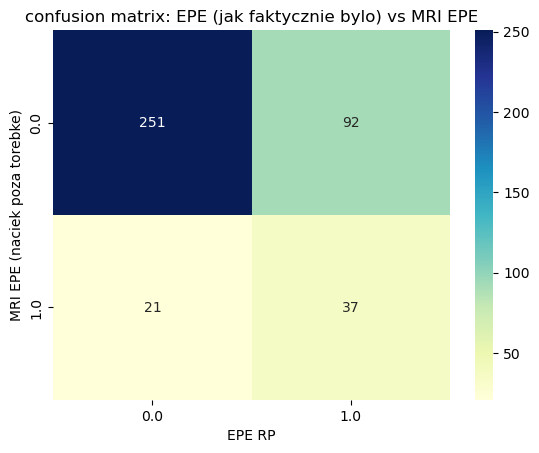

In [9]:
crosstab_data = pd.crosstab(
    df[col_mri_esur],
    df[target]
)

sns.heatmap(crosstab_data, annot=True, fmt='d', cmap='YlGnBu')

plt.title(f'confusion matrix: EPE (jak faktycznie bylo) vs MRI EPE')

plt.show()

Sensitivity = 28.68% (mri where existent epe)
Specificity = 92.28% (mri results where non existent epe)
Accuracy = 71.82%

# Modeling 

In [20]:
from unified_functions import get_model_pipeline, tune_hyperparameters, train_and_evaluate_model, plot_roc, plot_confusion_matrix, plot_feature_importances, plot_discrimination_threshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [13]:
before_biopsy_all = [target, col_wiek, col_psa, col_mri_vol, col_pirads, col_mri_esur, col_mri_size, col_mri_svi]
continueous = [col_wiek, col_psa, col_mri_vol, col_mri_size]
categorical = [col_pirads, col_mri_esur, col_mri_svi]


In [14]:
model_df = df[df['EPE RP'].isnull()==False]

X = model_df[continueous + categorical]
y = model_df[target]

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBClassifier(random_state=2)

In [15]:
y_true, y_pred, y_pred_probs, fpr, tpr, roc_auc, model_pipeline, best_params = train_and_evaluate_model(
    model=model,
    X=X,
    y=y,
    numerical_cols=continueous,
    categorical_cols=categorical,
    n_folds=5,
    tune_params=True,
    param_grid=param_grid,
    tuning_scoring='neg_brier_score',
    tuning_test_size=0.2
)

untrained_model = model.set_params(**best_params)

Tuning hyperparameters...



KeyboardInterrupt: 

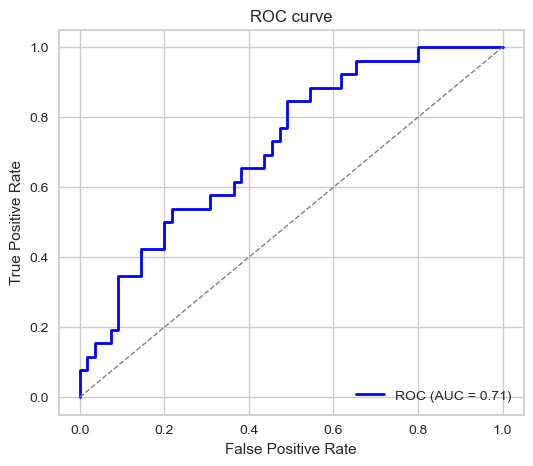

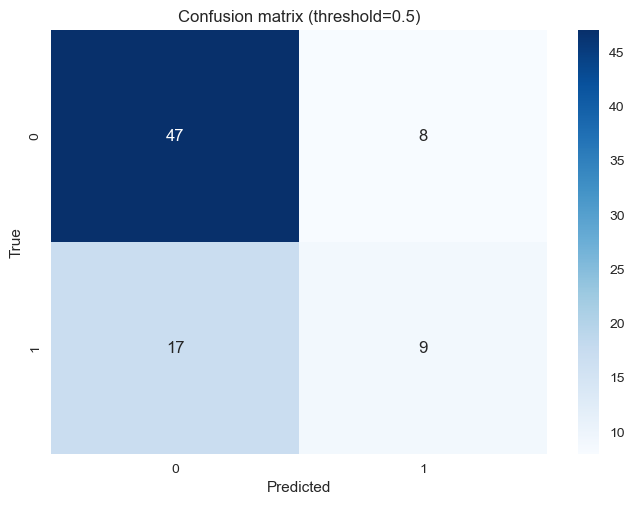

Preparation of a new explainer is initiated

  -> data              : 401 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001C31D390F40> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0101, mean = 0.32, max = 0.962
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.715, mean = 0.00167, max = 0.929
  -> model_info        : package sklearn

A new explainer has been created!


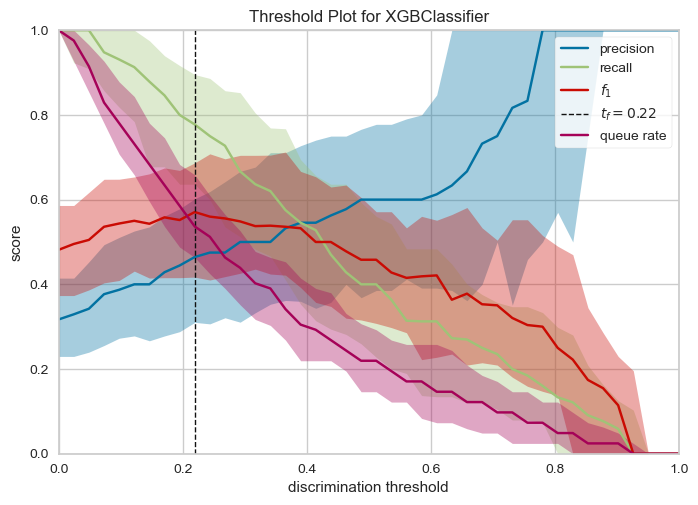

In [ ]:
plot_roc(fpr, tpr, roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(model_pipeline, X, y)
plot_discrimination_threshold(untrained_model, X, y)

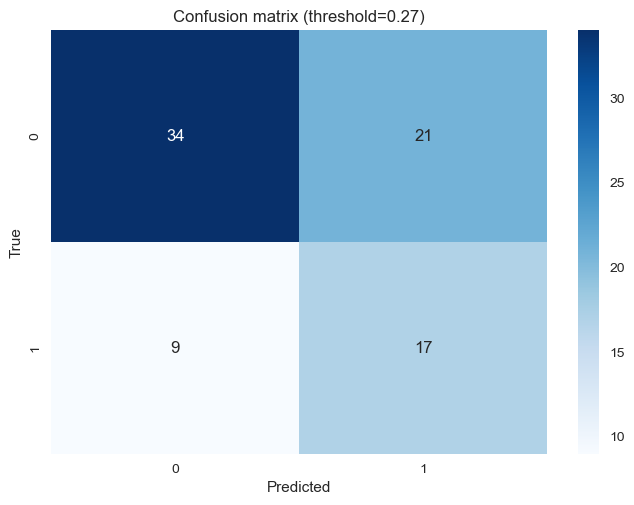

In [ ]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.27)

In [ ]:
from imblearn.over_sampling import SMOTE

Tuning hyperparameters...

Best hyperparameters: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 9, 'classifier__n_estimators': 800, 'classifier__subsample': 1.0}
Best neg_brier_score score: -0.1754686847326611

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 800, 

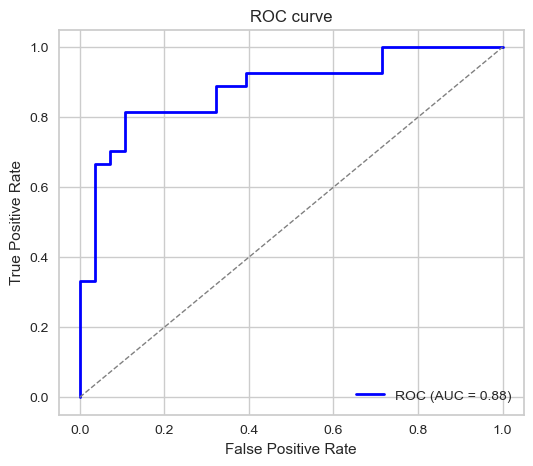

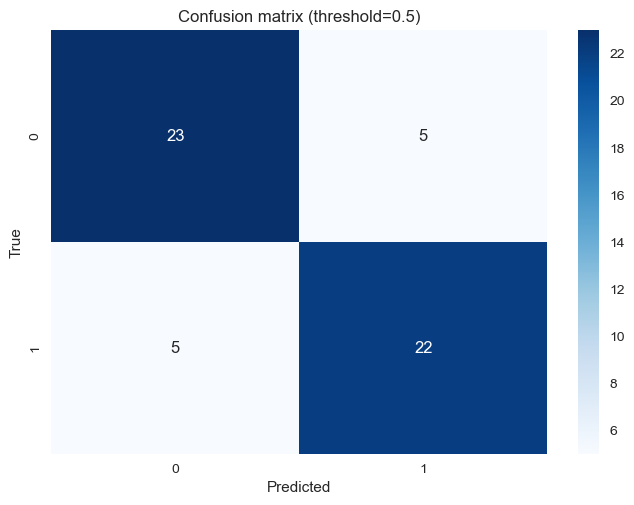

Preparation of a new explainer is initiated

  -> data              : 401 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001C31D390F40> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0109, mean = 0.339, max = 0.986
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.953, mean = -0.0176, max = 0.95
  -> model_info        : package sklearn

A new explainer has been created!


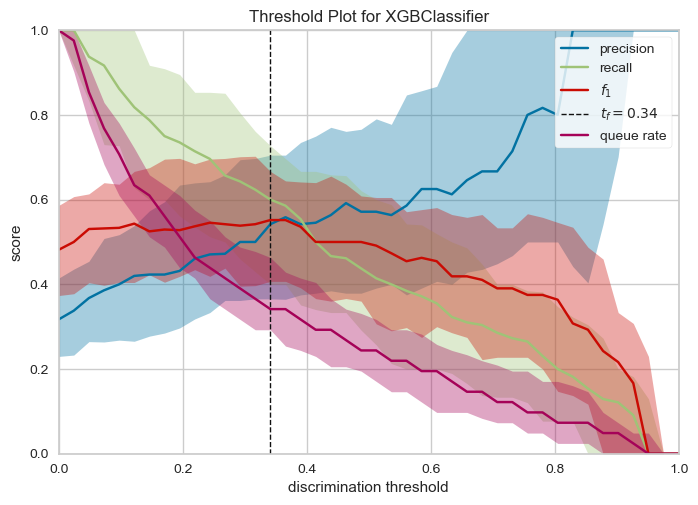

In [ ]:
model = XGBClassifier(random_state=2)
X = model_df[continueous + categorical]
y = model_df[target]

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, continueous),
    ('cat', cat_pipeline, categorical)
])

preprocessor.fit(X)
X_imputed = preprocessor.transform(X)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_imputed, y)
X_smote_df = pd.DataFrame(X_smote, columns=continueous + categorical)

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

#brier score and tuning test split = 0.1
y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model, best_params = train_and_evaluate_model(
    model, X_smote_df, y_smote, continueous, categorical, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='neg_brier_score', tuning_test_size=0.1
    )
untrained_model = model.set_params(**best_params)

plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)

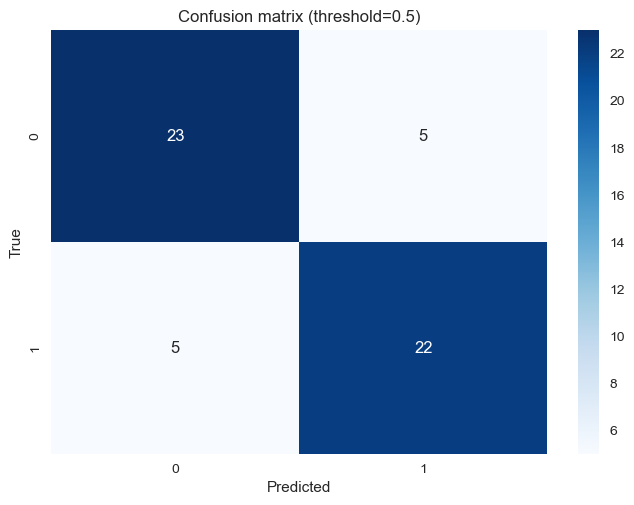

In [ ]:
plot_confusion_matrix(y_true, y_pred, threshold=0.5)

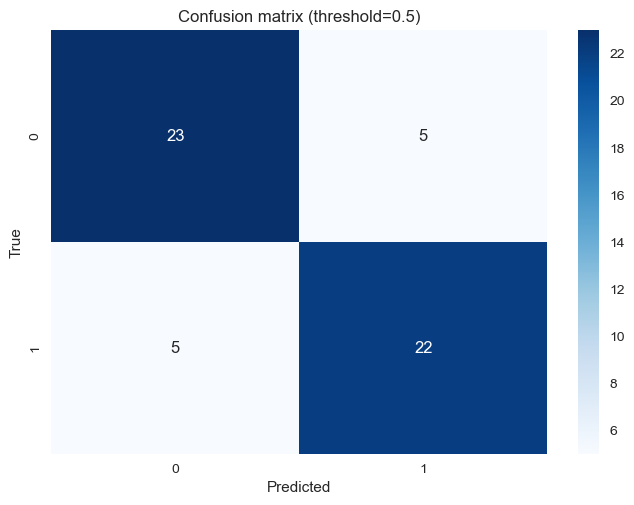

In [ ]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.5)

In [ ]:
def train_and_evaluate_model_with_smote(
    model, X, y, numerical_cols, categorical_cols,
    n_folds=5, tune_params=False, param_grid=None,
    tuning_scoring='roc_auc', tuning_test_size=0.2
):
    y_pred_probs = np.array([])
    y_pred = np.array([])
    y_true = np.array([])

    if not tune_params:
        print("Training model with default hyperparameters...\n")

        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            num_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
            cat_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent'))])
            preprocessor = ColumnTransformer(transformers=[
                ('num', num_pipeline, numerical_cols),
                ('cat', cat_pipeline, categorical_cols)
            ])

            X_train_imputed = preprocessor.fit_transform(X_train)
            X_test_imputed = preprocessor.transform(X_test)

            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)
            
            X_train_smote = pd.DataFrame(X_train_smote, columns=numerical_cols + categorical_cols)

            model.fit(X_train_smote, y_train_smote)

            y_pred_prob_fold = model.predict_proba(X_test_imputed)[:, 1]
            y_pred_fold = model.predict(X_test_imputed)

            y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
            y_pred = np.concatenate([y_pred, y_pred_fold])
            y_true = np.concatenate([y_true, y_test])

            print(f"Fold {i}: ROC AUC = {roc_auc_score(y_test, y_pred_prob_fold):.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        total_roc_auc = roc_auc_score(y_true, y_pred_probs)
        best_params = model.get_params()
        print(f"\nOverall ROC AUC across folds: {total_roc_auc:.4f}")

        return y_true, y_pred, y_pred_probs, fpr, tpr, total_roc_auc, model, best_params

    else:
        print("Tuning hyperparameters with SMOTE on training set only...\n")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=tuning_test_size, stratify=y, random_state=42
        )

        num_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
        cat_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent'))])
        preprocessor = ColumnTransformer(transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', cat_pipeline, categorical_cols)
        ])

        X_train_imputed = preprocessor.fit_transform(X_train)
        X_test_imputed = preprocessor.transform(X_test)

        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

        X_train_smote = pd.DataFrame(X_train_smote, columns=numerical_cols + categorical_cols)
        best_params = tune_hyperparameters(
            model, param_grid, X_train_smote, y_train_smote,
            numerical_cols, categorical_cols, n_folds=3, scoring=tuning_scoring
        )
        model.set_params(**best_params)
        print(f"Best params after tuning:\n{best_params}")

        model.fit(X_train_smote, y_train_smote)

        y_pred_probs = model.predict_proba(X_test_imputed)[:, 1]
        y_pred = model.predict(X_test_imputed)
        y_true = y_test

        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        total_roc_auc = roc_auc_score(y_test, y_pred_probs)
        print(f"\nROC AUC on test set: {total_roc_auc:.4f}")

        return y_true, y_pred, y_pred_probs, fpr, tpr, total_roc_auc, model, best_params


Tuning hyperparameters with SMOTE on training set only...

Best hyperparameters: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 800, 'classifier__subsample': 1.0}
Best neg_brier_score score: -0.16784094293097632

Best params after tuning:
{'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 800, 'subsample': 1.0}

ROC AUC on test set: 0.6762


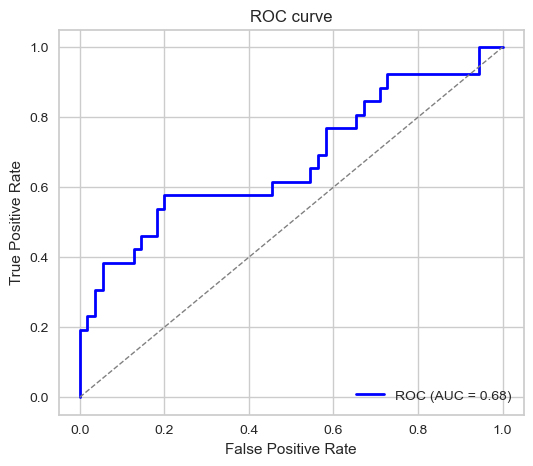

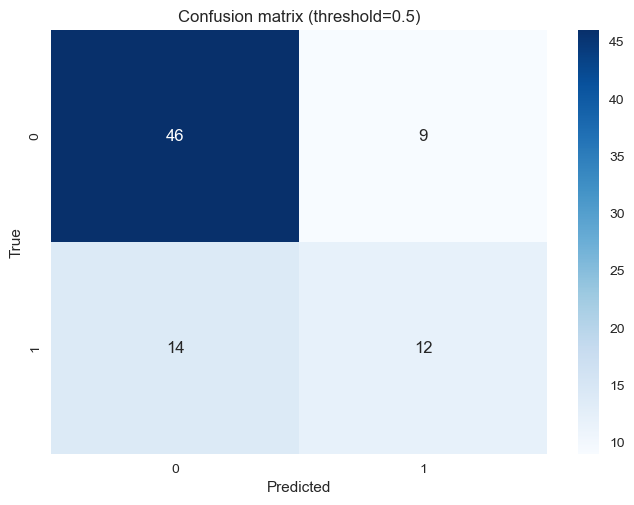

Preparation of a new explainer is initiated

  -> data              : 401 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001C31D390F40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0153, mean = 0.334, max = 0.982
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.878, mean = -0.0127, max = 0.969
  -> model_info        : package xgboost

A new explainer has been created!


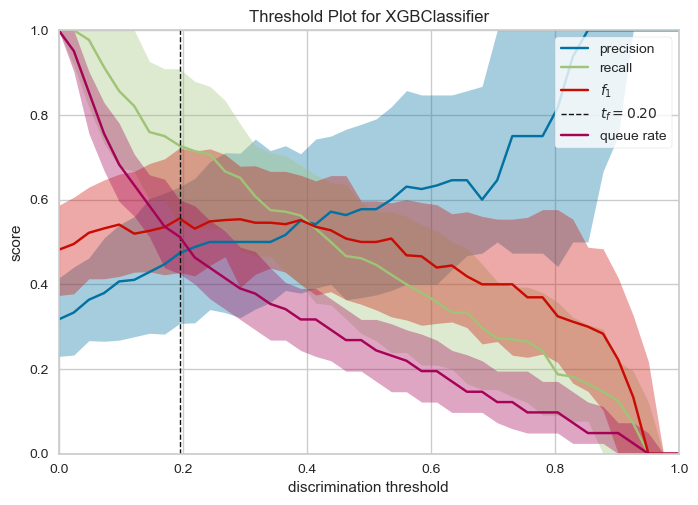

In [ ]:
X = df[continueous + categorical]
y = df[target]

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBClassifier(random_state=2)
#brier score and tuning test split = 0.2


y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model, best_params = train_and_evaluate_model_with_smote(model, X, y, continueous, categorical, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='neg_brier_score', tuning_test_size=0.2)
untrained_model = model.set_params(**best_params)

plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)

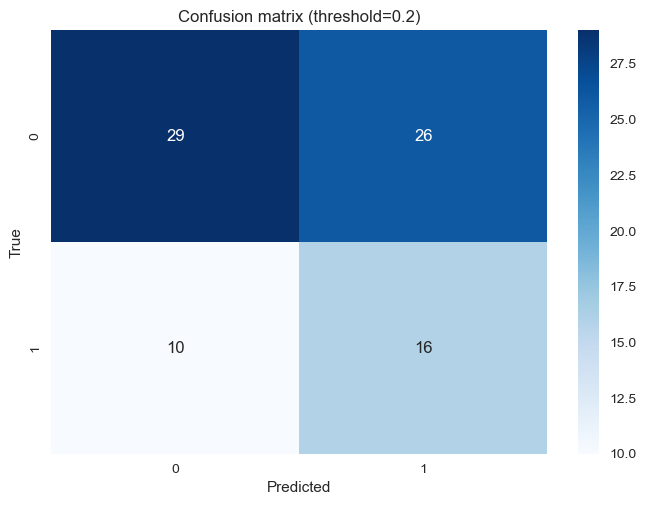

In [ ]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.20)

In [16]:
# psa_mri_vol_ratio = []
# for psa, mri_vol in zip(df[col_psa], df[col_mri_vol]):
#     if mri_vol != "0":
#         psa_mri_vol_ratio.append(str(float(psa) / float(mri_vol)))
#     else:
#         psa_mri_vol_ratio.append("0")

# bins = [0, 59, 70, np.inf]

# labels = ['poniżej 60', '60-70', 'powyżej 70']

# col_wiek = pd.cut(df['wiek'], bins=bins, labels=labels, right=True)

# continueous = [col_wiek, col_psa, col_mri_vol, col_mri_size, psa_mri_vol_ratio]
# categorical = [col_pirads, col_mri_esur]

continueous = [col_wiek, col_psa, col_mri_vol, col_mri_size]
categorical = [col_pirads, col_mri_esur]

In [26]:
from scipy.stats import uniform, randint
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model_df = df[df['EPE RP'].isnull()==False]

X = model_df[continueous + categorical]
y = model_df[target]

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800, 1000],
    'classifier__max_depth': [1, 2, 3, 4],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__reg_lambda': [0.1, 1.0, 10.0],
    'classifier__reg_alpha': [0, 0.1, 1.0],
    'classifier__min_child_weight': [1, 5, 10]
}


model1 = XGBClassifier(random_state=2, scale_pos_weight=1.97)
model2 = RandomForestClassifier(random_state=2, class_weight='balanced')
model3 = LogisticRegression(
    random_state=2, 
    class_weight='balanced', 
    max_iter=1000, 
    solver='saga'
)
model4 = LGBMClassifier(random_state=2, class_weight='balanced')
model5 = CatBoostClassifier(
    random_state=2, 
    scale_pos_weight=1.97,
    verbose=0
)

In [29]:
y_true, y_pred, y_pred_probs, fpr, tpr, roc_auc, model_pipeline, best_params = train_and_evaluate_model(
    model=model1,
    X=X,
    y=y,
    numerical_cols=continueous,
    categorical_cols=categorical,
    n_folds=5,
    tune_params=True,
    param_grid=param_grid,
    tuning_scoring='neg_brier_score',
    tuning_test_size=0.2
)

untrained_model = model.set_params(**best_params)

Tuning hyperparameters...

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 1, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 2, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': 1.97, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Total scores:
ROC AUC score: